## Introduction

The purpose of this project is to choose an image dataset and then develop an image classification algorithm using a neural network.

In [2]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [3]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import requests
import keras
import keras_tuner
from keras import layers, regularizers
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, TensorBoard

## Load Data

This project uses the fashion_mnist dataset. It's comprised of 28 x 28 grayscale images spanning 10 types of clothing.

In [4]:
from keras.datasets import fashion_mnist

The code below creates and looks at a train test split

In [5]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [6]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


From this we can see that were using 60,000 images on the training dataset and 10,000 on the test dataset.

The code below looks at the actual images within the data set

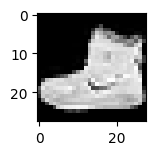

9


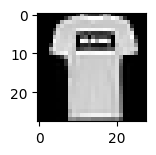

0


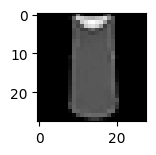

0


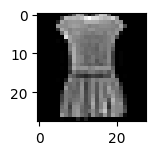

3


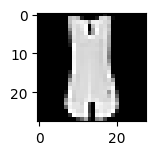

0


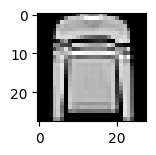

2


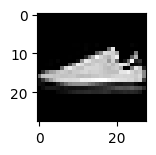

7


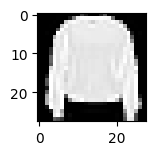

2


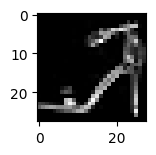

5


In [7]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
  plt.show()
  print(train_y[i])

We can see that some classes of the dataset might be harder to distinguish from others. For example a sneaker vs sandals or pull-over vs shirt.

## Data Preparation

In [17]:
train_X

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

The code below converts this data to a one dimensional array

In [8]:
#converting to a one dimensional array
X_train = train_X.reshape(train_X.shape[0], -1)
X_test = test_X.reshape(test_X.shape[0], -1)

In [9]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Looking at the output we can see it's been successfully changed to a one dimensional array

The code below normalizes the data

In [10]:
#normalization
X_train_norm = X_train / 255
X_test_norm = X_test / 255

## Analysis

This is a funtcion with 5 parameters that creates our neural network model.

In [11]:
def define_model(units, num_layers, activation, lr, l2):
    model_layers = [
        layers.Dense(units, activation=activation, kernel_regularizer=regularizers.L2(l2=l2), kernel_initializer=keras.initializers.HeNormal())
        ] * num_layers  # These are the main hidden layers
    model_layers += [layers.Dense(10)]  # 10 output layers for 10 classes
    model = keras.Sequential(model_layers)  # This just stacks all our layers on top of each other
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
     #Sparse categorical crossentropy used for compiling multi-class digit classification
     #metrics assigned to track accuracy

    return model

This code sets the hyperparameters and then calls the previous function. l2 regularization (ridge) is used due to generalization and the nature of our features being pixels

In [12]:
def build_model(hp):
    units = hp.Choice("units", [256, 512, 1024]) #256 - 1024 units per layer
    activation = "relu"   # We'll just use ReLu for now
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-5, max_value=1e-1, sampling="log")
    num_layers = hp.Choice("num_layers", [2, 5]) #2 - 5 hidden layers

    # call existing model-building code with the hyperparameter values.
    model = define_model(units=units, num_layers=num_layers, activation=activation, lr=lr, l2=l2)
    return model

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The code below initializes the tuner and sets the number of trials to 10

In [14]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss", # We want to see accuracy improve on the validation (or test) dataset
    max_trials=10,  #10 parameter combinations
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive/FashionMnistResult", # Save the output somewhere you've created
)

Reloading Tuner from /content/drive/MyDrive/FashionMnistResult/untitled_project/tuner0.json


In [15]:
# This is a "callback" function, which will get called at the end of every epoch to check whether the accuracy is still increasing
callbacks = [EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, start_from_epoch=5)]

In [ ]:
train_y.shape

(60000,)

In [ ]:
tuner.search(
    X_train_norm,
    train_y,
    epochs=10,
    verbose=1, #set to 1 in order to look at a progress bar
    validation_data=(X_test_norm, test_y),
    callbacks=callbacks
)

In [ ]:
# Examining the results
tuner.results_summary(5)  # printing out the top 5 models

Results summary
Results in /content/drive/MyDrive/FashionMnistResult/untitled_project
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
units: 256
lr: 0.0009812099810752397
l2: 1.993140220138288e-05
num_layers: 5
Score: 0.360119104385376

Trial 04 summary
Hyperparameters:
units: 1024
lr: 0.0015064321002527241
l2: 1.3552820418325684e-05
num_layers: 2
Score: 0.3728286623954773

Trial 09 summary
Hyperparameters:
units: 1024
lr: 5.685378663535912e-05
l2: 0.00270570561993386
num_layers: 5
Score: 0.49622100591659546

Trial 06 summary
Hyperparameters:
units: 256
lr: 0.004621959590285652
l2: 0.0011011540721501195
num_layers: 2
Score: 0.5403092503547668

Trial 01 summary
Hyperparameters:
units: 512
lr: 0.0001320105670093872
l2: 0.04410320856052372
num_layers: 2
Score: 0.6169450879096985


After looking at each model we choose the best performing one (aka the one with the lowest score). In this case it was trial number 2

In [ ]:
import json
from sklearn.metrics import confusion_matrix

trial_num = "02" #best performing model number
with open(f"/content/drive/MyDrive/FashionMnistResult/untitled_project/trial_{trial_num}/trial.json", "r") as f:
    trial = json.load(f)
hp = trial["hyperparameters"]["values"]
model = define_model(units=hp["units"], num_layers=hp["num_layers"], activation="relu", lr=hp["lr"],
                     l2=hp["l2"])

model.load_weights(f"/content/drive/MyDrive/FashionMnistResult/untitled_project/trial_{trial_num}/checkpoint")

This code calculates the accuracy of the test and displays the confusion matrix

In [ ]:
y_pred = np.argmax(model.predict(X_test_norm), axis=1)
cm = confusion_matrix(test_y, y_pred) #creating confusion matrix
accuracy = sum(y_pred == test_y) / len(test_y) #calculating accuracy
print(accuracy)
print(cm)

313/313 [==============================] - 1s 4ms/step
0.8825
[[872   0  16  20   2   2  80   0   8   0]
 [  4 963   0  24   4   0   3   0   2   0]
 [ 23   1 809  10  65   1  82   0   9   0]
 [ 27   4   8 896  34   0  26   0   5   0]
 [  2   1 110  23 741   0 116   0   7   0]
 [  0   0   0   0   0 965   0  21   1  13]
 [149   0  72  29  39   0 687   0  24   0]
 [  0   0   0   0   0  11   0 964   3  22]
 [  6   0   2   4   2   3   2   2 979   0]
 [  1   0   0   0   0   5   0  45   0 949]]


From this we can see that the model is accurate 88.25% of the time. This is a substantially higher accuracy than if we were guessing randomly which demonstrates that it can be a useful tool in this particular case.